# **Data extraction project from the youtube api and its import into an AWS database.**



---
## **Extractig information from youtube API**


---




For this project, I want to extract information from the videos of a channel and their respective statistics. According to the documentation, to do this it is necessary to make two calls to the api. One will collect just the videos of a channel (its id, title and publication date), while the other one will get the statistics (likes, comments, views).

To create a call we will use the requests library with the get() method. However, before starting it is important to have registered as a developer and to have a key to make calls to the api (in the code cell, I have hidden my key by changing it to a series of x's). You can find how to do it in the read me of this repository. Other libraries I will use in this part are the pandas library (to create a dataframe to store the data) and time (to add a waiting period between a call to the api and the next part of the code).

In [1]:
#Import libraries
import requests
import pandas as pd
import time

In [2]:
#Assign key and channel id to a variable
api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
channel_id = 'UCDM4gHuLmONC_NtESLi_V1g' 

Back to the calls, it is important to understand **that to make a call we must use a url address provided by the documentation along with a series of parameters that will define the type of information we want to obtain**. 
Once we have the complete address, we pass it as an argument to the get() method and obtain the results in json() format.

As I mentioned before, **we must make two calls to get all the information** we want. However, for the second call it is necessary to have the video_id of each video from which we want to get statistics. That means that we cannot make that call without having made the first one before. And what is even more important, it would be optimal not to pass more than one video_id at a time in this second call.

**To solve this problem it is necessary to create two functions. One will make the second call to the api taking video_id as parameter and returning the values of view_count, like_count and comment_count.**

In [3]:
def get_video_details(video_id):

  #Making api call to obtain statistics information
  url_video_stats = 'https://www.googleapis.com/youtube/v3/videos?id='+video_id+'&part=statistics&key='+api_key
  response_video_stats = requests.get(url_video_stats).json()

  view_count = response_video_stats['items'][0]['statistics']['viewCount']
  like_count = response_video_stats['items'][0]['statistics']['likeCount']
  comment_count = response_video_stats['items'][0]['statistics']['commentCount']

  return view_count, like_count, comment_count

**The other one will make a call to obtain the video_id and other required variables**, and will save it in a variable called "response". In this same function **a loop will also be created so that, for each video_id within items, the values are assigned to the variables** (taking advantage of the use of the previous function to obtain the statistics data) and **save them in a dataframe**.

In [4]:
def get_videos(df):
  #Making API call to obtain video information
  pageToken = ''
  url = 'https://www.googleapis.com/youtube/v3/search?key='+api_key+'&channelId='+channel_id+'&part=snippet,id&order=date&maxResults=1000'+pageToken

  response = requests.get(url).json()
  time.sleep(1)

  #Creating a loop inside items key
  for video in response['items']:
    if video['id']['kind'] == 'youtube#video':
      video_id = video['id']['videoId']
      video_title = video['snippet']['title']
      upload_date = video['snippet']['publishedAt']
      upload_date = str(upload_date).split("T")[0]

      #Using get_video_details function to obtain more information
      view_count, like_count, comment_count = get_video_details(video_id)

      #Saving all data into pandas df
      df = df.append({'video_id': video_id, 
                      'video_title': video_title, 
                      'upload_date': upload_date, 
                      'view_count': view_count, 
                      'like_count': like_count, 
                      'comment_count': comment_count},
                    ignore_index = True)
      
  return df

In short, this function will do the following. **First it makes a call to the api that returns information in json format of all the videos of a channel** (in this case I have selected the uri vyce channel but you can see the readme to know how to find the id of any other channel).

This json has a **key called items that contains all the ids, titles and publication dates of each video**. To access the information for each video separately and store it in a dataframe, we create a **loop that iterates over each video in items**. 

Then, for the first video, we first check that the content is of type video. If so, the id, title and date information is accessed and stored in several variables. Then, we apply the function get_video_details passing the parameter video_id, which we just saved in the variable and thus obtain the metrics of that particular video. Already having the data of the first video in the variables, we save the values in a dataframe using append(). 

After this, the second video is passed inside items and the loop is repeated until there are no more videos in the json. **The function finishes returning the dataframe with all the saved data**.

Now, **we have created the functions but we don't have the data yet**. We start by creating an empty dataframe since it is the argument of the get_videos function. Once created, we apply the function and we can see that the dataframe has been filled with the information we wanted.

In [5]:
#Create empty dataframe and get data
df = pd.DataFrame(columns = ['video_id', 'video_title', 'upload_date', 'view_count', 'like_count', 'comment_count'])
df = get_videos(df)

In [6]:
#Show results
df.head(10)

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,e2g0hPK_4oA,La Decisión Más Importante De Mi Carrera,2023-02-02,16557,1786,161
1,ZMEo0LDVtDA,💥 Cómo Aprovechar la Crisis Inmobiliaria en Es...,2023-01-18,138205,7225,439
2,W1Ghb9J8ewE,¿Habías Oído Hablar de este Trabajo? 😎,2023-01-16,103451,3275,62
3,BAu1gM-IIGU,Cuánto He Ganado Como Youtuber en 2022,2023-01-09,68879,4503,442
4,6-N-0Q0cKwc,He Fracasado,2023-01-01,122587,8971,739
5,PjnCguGtmFA,🔴 Lo que se viene en 2023 (ÚLTIMO DIRECTO DEL ...,2022-12-30,32895,1292,150
6,yStOpp8Gq0c,7 Trabajos Desde Casa y Sin Experiencia Para G...,2022-12-26,106660,6207,463
7,m1p2etKZawM,¿Es Suiza un buen lugar para 𝗩𝗜𝗩𝗜𝗥? 🏠⁠,2022-12-23,15213,614,13
8,r7LqMHTAuRk,Cómo Te Afecta la Crisis Energética Mundial 2023,2022-12-21,20956,2026,250
9,jHnPYL-U7Ew,EL ANUNCIO MÁS IMPORTANTE DEL AÑO (para tu bol...,2022-12-19,71374,6886,278




---
## **Import dataframe to a database**


---




### **Connecting to the database with python**

We start by installing and importing a library that will allow us to connect to postgresql from python.

In [7]:
#Import psycopg2 to connect to a PostgreSQL database from Python
!pip install psycopg2
import psycopg2 as ps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We use variables to store the database access credentials (again, I have hidden my keys).

In [8]:
#Save credentials of AWS database in variables
host_name = 'xxxxxxxxxxxxx.amazonaws.com'
dbname = 'xxxxxxx'
port = '5432'
username = 'xxxxxxxxx'
password = 'xxxxxxxxxxxxxxxxxx'
conn = None

We create a function that returns a variable containing the connection to the database (using the credentials) and, if it does not work, returns an error.

In [9]:
#Create a function to connect to AWS database
def connect_to_db(host_name, dbname, port, username, password):
  try:
    conn = ps.connect(host=host_name, database = dbname, user = username, password = password, port = port)
  except ps.OperationalError as e:
    raise e
  else:
    print('Connected!')

  return conn

In [10]:
#Using the connect_to_db function
conn = connect_to_db(host_name, dbname, port, username, password)

Connected!


### **Create table and add data to database from python using SQL**

Currently, we have the API data stored in a dataframe.

In [11]:
df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,e2g0hPK_4oA,La Decisión Más Importante De Mi Carrera,2023-02-02,16557,1786,161
1,ZMEo0LDVtDA,💥 Cómo Aprovechar la Crisis Inmobiliaria en Es...,2023-01-18,138205,7225,439
2,W1Ghb9J8ewE,¿Habías Oído Hablar de este Trabajo? 😎,2023-01-16,103451,3275,62
3,BAu1gM-IIGU,Cuánto He Ganado Como Youtuber en 2022,2023-01-09,68879,4503,442
4,6-N-0Q0cKwc,He Fracasado,2023-01-01,122587,8971,739


The goal is to get that data into a cloud database (in this case AWS). To do this, we must first create a table, which we can accomplish by creating an SQL query and executing it from python.

In [12]:
#Create table function
def create_table(curr):
  create_table_command = ("""CREATE TABLE IF NOT EXISTS videos(
                      video_id VARCHAR(25) PRIMARY KEY,
                      video_title TEXT NOT NULL,
                      upload_date DATE NOT NULL DEFAULT CURRENT_DATE,
                      view_count INTEGER NOT NULL,
                      like_count INTEGER NOT NULL,
                      comment_count INTEGER NOT NULL
                    );""")
  
  curr.execute(create_table_command)

The query creates the table respecting the order of the columns of the dataframe. On the other hand, it is inside a function called create_table whose purpose is to execute the query. 

The parameter curr is the one that will allow to perform the query and extract the data from the database. To do this, curr must contain the connection variable (conn) that we built before together with the cursor() command. This command allows us to execute the queries and obtain results from the database. 

In [13]:
#Define curr 
curr = conn.cursor()

In [14]:
#Using create_table function
create_table(curr)

#Commit the code
conn.commit()

Once this is done, the table will have been created, which we can check if we do a SELECT in postgreSQL.



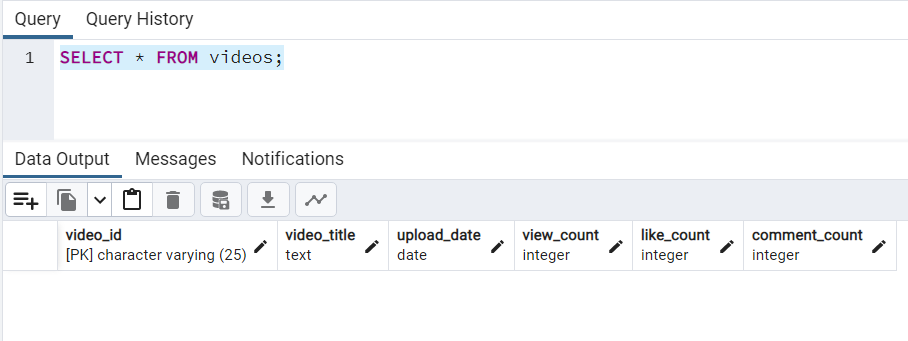

### **Create functions to update or add information**

As you can see, the table is empty. To aggregate the dataframe data we will have to create aggregation and update commands. Why? Because the data we have (video_id, like_count,...) are changing as visits increase and users interact with the content. At the same time, the channel owner can upload new videos. So, it is pertinent in this case to create functions that add the new videos to the table and update the information of the existing ones.

We will start by creating the two functions and then use them within another function that will define which function to use, depending on whether the video (from the dataframe) exists or not in the table in which we insert the data.

In [15]:
#Create a function to check if a video already exists in the table and return the row if that is the case
def check_if_video_exists(curr, video_id):
  query = ("""SELECT video_id FROM videos WHERE video_id = %s;""")
  curr.execute(query, (video_id,))

  return curr.fetchone() is not None

This function executes a SQL query by using execute and curr, as we saw before.

It highlights the use of %s, which is a parameter that acquires the video_id value of the dataframe. Then, the query will look for the video_id value of the videos table that is equal to the video_id value of the dataframe.

In the execute parameters we put the query and, as we have used %s inside the query, we must also add the variable from which it takes the value. It is passed forming a tuple, that's why video_id is in parenthesis and with a comma. Finally, we ask the function to return the table row (fetchone()).

Then, the function does the following. It uses the parameters curr and video_id to execute a query in the database. This query consists of selecting the video_id that is also in the dataframe. If it finds it, it returns us the row (since it is in the table). If not, it cannot return a result so it returns None.

In [16]:
#Create a function to update the row that exists in the table
def update_row(curr, video_id, video_title, view_count, like_count, comment_count):
  query = ("""UPDATE videos
              SET video_title = %s,
                view_count = %s,
                like_count = %s,
                comment_count = %s
              WHERE video_id = %s;""")
  vars_to_update = (video_title, view_count, like_count, comment_count, video_id)
  curr.execute(query, vars_to_update)

Here we do something similar only changing the query. We define a query that updates the data in the videos table where video_id corresponds to the id of our dataframe. We define again the values of the dataframe with the parameter %s.

To execute we pass again the query and the variables that will be used for the parameter %s, only that we put them in a variable (vars_to_update) to facilitate the readability of the code.

In the parameters of the function we put curr, which is the variable that we created before and uses our connection to the database and the cursor() function to execute the SQL query, together with the variables of our dataframe.

In [17]:
#Create a function that updates the database using previous functions
def update_db(curr,df):
  #Create temporary dataframe to store rows that are not in the table (new videos)
  temp_df = pd.DataFrame(columns = ['video_id', 'video_title', 'upload_date', 'view_count', 'like_count', 'comment_count'])

  #Check if video exists and determine what to do
  for i, row in df.iterrows():
    if check_if_video_exists(curr, row['video_id']): #If video exists then we will update
      update_row(curr, row['video_id'], row['video_title'], row['view_count'], row['like_count'], row['comment_count'])
    else: #If video doesn't exists we will append to the table
      temp_df = temp_df.append(row)

  return temp_df

The iterrows() function is a pandas library function that iterates over the rows of a dataframe, returning the row index and a series of row data. So the loop has i (index) and row (row data as a series).

The **first part of the loop** checks if the dataframe video already exists in the database table. It does this by executing the function we created earlier, which on the back end is doing a SQL query and returning the row in question if it turns out that the video is already in the table. In case the function returns the row, a function that updates it is applied. 

This function (update_row) also executes a SQL query in the backend and uses several parameters, among them video_id, video_title, etc. What happens is that we cannot write the names of the parameters as they are because we are inside a loop, where we only have access to an index and a series with data of a row (i, row). That's why we use row['video_id'] for example, to access the concrete data within the series.

The **second part of the loop** is executed when the first one does not return a result, which would mean that the video in question is new (not in the table). In that case, what happens is that the row is stored in a temporary dataframe created just before the loop, following the same structure as df.

All of the above is included inside the update_db function, which has as arguments the variable curr and the dataframe. Now **what is missing is to add a function that executes an INSERT query to add the rows of the temporary dataframe (temp_df) to the table**. That's why the function ends up returning temp_df.

In [18]:
#Using update_db function
new_vids_df = update_db(curr, df)

In [19]:
#Commit all SQL commands to the db
conn.commit()

The **first time we run this query no record will appear in the table** (you can check this by running SELECT * FROM videos in postgreSQL). This happens because as the table was empty (we had just created it) no video had to be updated. As a result, all the records from our dataframe have moved to the temporary dataframe as a result of running update_db, which are now in the new_vids_df variable.

In [20]:
new_vids_df.head()

,video_id,video_title,upload_date,view_count,like_count,comment_count
0,e2g0hPK_4oA,La Decisión Más Importante De Mi Carrera,2023-02-02,16557,1786,161
1,ZMEo0LDVtDA,💥 Cómo Aprovechar la Crisis Inmobiliaria en Es...,2023-01-18,138205,7225,439
2,W1Ghb9J8ewE,¿Habías Oído Hablar de este Trabajo? 😎,2023-01-16,103451,3275,62
3,BAu1gM-IIGU,Cuánto He Ganado Como Youtuber en 2022,2023-01-09,68879,4503,442
4,6-N-0Q0cKwc,He Fracasado,2023-01-01,122587,8971,739


Next we will create a command to insert all this data into the table.

In [21]:
#Create a function to insert values into the table
def insert_into_table(curr, video_id, video_title, upload_date, view_count, like_count, comment_count):
  insert_into_videos = ("""INSERT INTO videos (video_id, video_title, upload_date, view_count, like_count, comment_count)
                            VALUES(%s,%s,%s,%s,%s,%s);""")
  row_to_insert = (video_id, video_title, upload_date, view_count, like_count, comment_count)

  curr.execute(insert_into_videos, row_to_insert)

Done this, we are going to create a function that makes a loop that executes this new function for each video, instead of inserting all the data at once. This way we will avoid performance problems.

In [22]:
def append_from_df_to_db(curr, df):
  for i, row in df.iterrows():
    insert_into_table(curr, row['video_id'], row['video_title'], row['upload_date'], row['view_count'], row['like_count'], row['comment_count'])

Now we can run the function and add the data from the temporary dataframe.

In [23]:
#Using new function to append new videos from temporary df to the table
append_from_df_to_db(curr, new_vids_df)

In [24]:
#Commit SQL queries
conn.commit()

Now the data will have been added to the table, which we can check by means of a query.

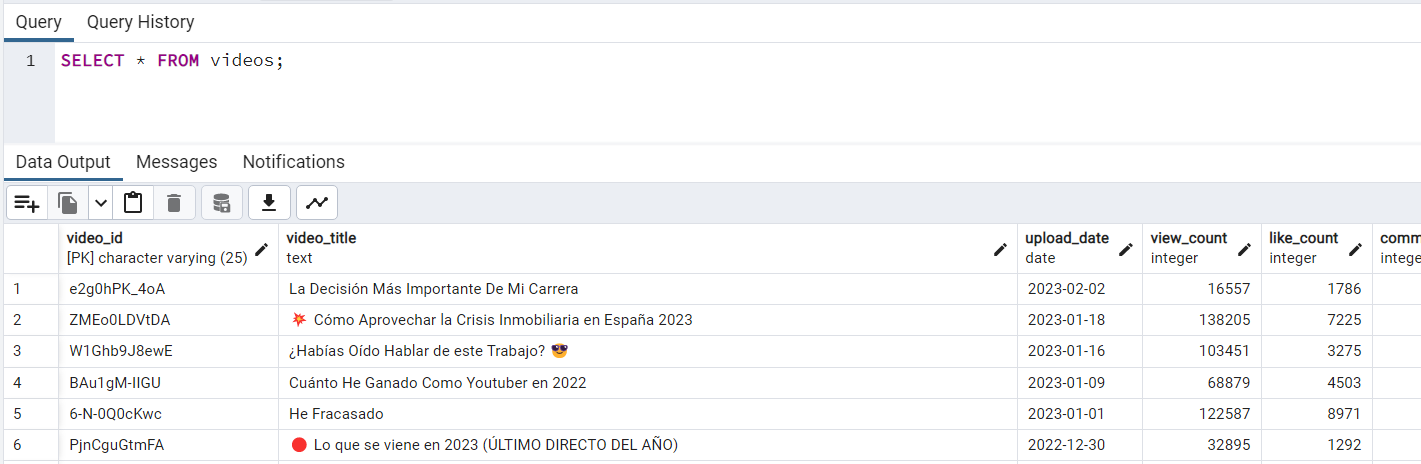